# divide observations into watermasses based on location

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import cmocean as cm
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
len(obs)

3464571

In [4]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
len(obs)

1931750

In [6]:
# depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
len(obs)

1827315

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

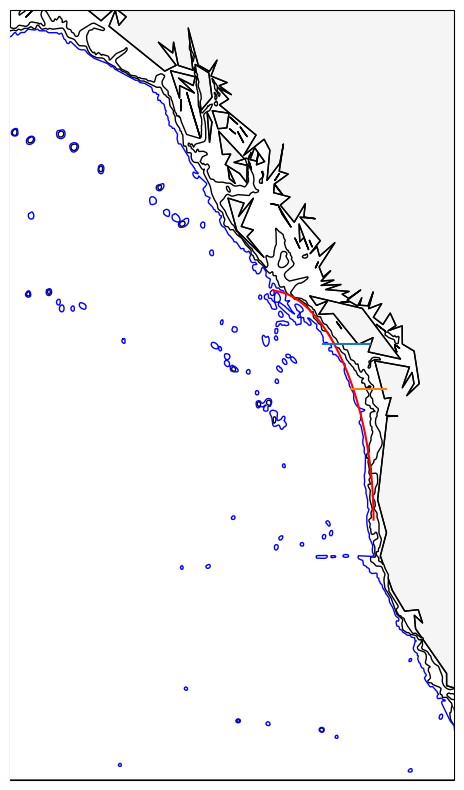

In [8]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))


# offshore cuttoff 
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [49]:
# Load the bathymetry shapefile
bathymetry = gpd.read_file("./ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

In [50]:
contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.unary_union)

In [51]:
# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

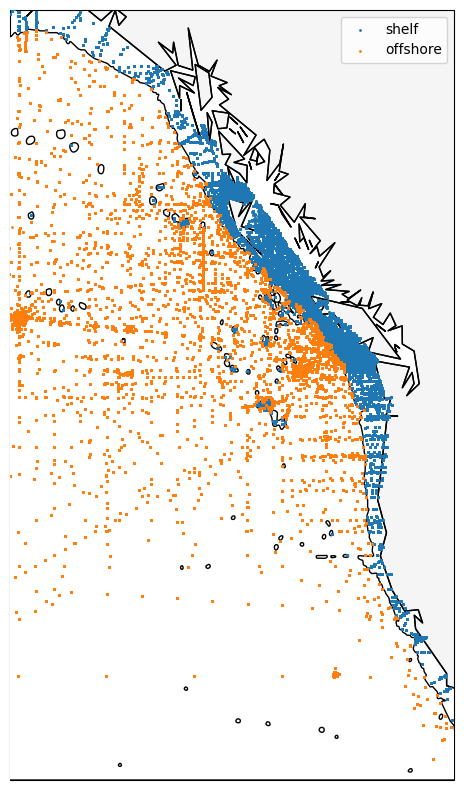

In [53]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs_gdf['longitude (degrees_east)'][obs_gdf.location_type == 'shelf'],obs_gdf['latitude (degrees_north)'][obs_gdf.location_type == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs_gdf['longitude (degrees_east)'][obs_gdf.location_type == 'offshore'],obs_gdf['latitude (degrees_north)'][obs_gdf.location_type == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')
ax.legend()


In [9]:
# code for separating observations into groups based on location and depth
def region(lat,lon,salinity,d):
    if  lon < np.sqrt((1-(((lat-42)**2)/(9**2)))*(6**2))-130.8:
        return 1 #offshore
    elif lat > 49:
        return 2 #north
    elif lat < 47.3:
        if salinity >= 33.9:
            return 3 #south deep
        elif salinity < 32:
            return 4 #south fresh
        else:
            return 5 #south shelf
    else:
        return 6  #domain

regions = ['Offshore', 'North', 'South Deep', 'South Fresh', 'South Shelf']

In [10]:
obs['region'] = [region(obs['latitude (degrees_north)'][i],obs['longitude (degrees_east)'][i],obs['salinity (g kg-1)'][i],obs['depth (m)'][i]) for i in range(len(obs))]

In [11]:
# separate summer and winter
obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

wob = obs[(obs.month >=11) | (obs.month <=2)]
sob = obs[(obs.month >= 5) & (obs.month <=8)]

In [12]:
# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

## South

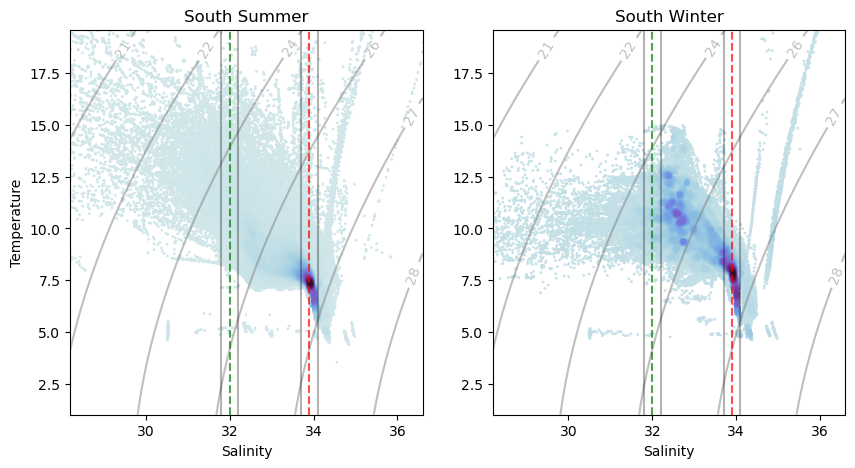

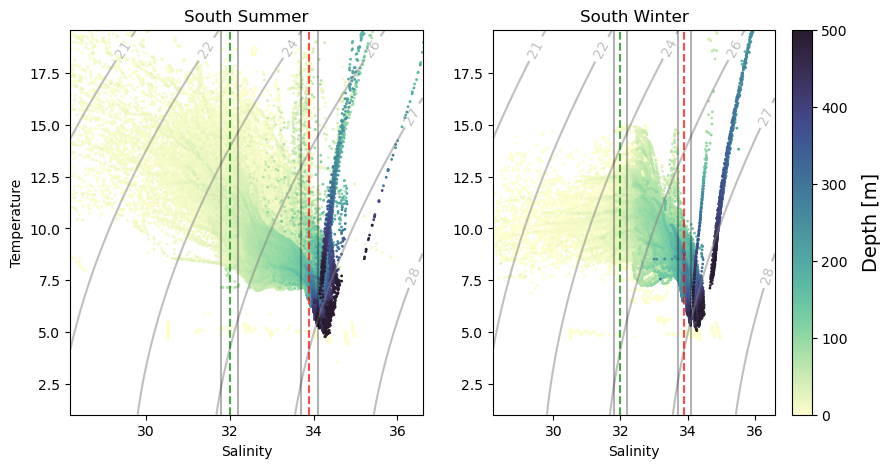

In [13]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)

bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "South Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[1].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "South Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply boundaries from CIOPS analysis
    # division between water masses
    ax[i].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
    ax[i].plot([34.1,34.1],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([33.7,33.7],[tmin,tmax],'k', alpha=0.3)

    # columbia delineation
    ax[i].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
    ax[i].plot([32.2,32.2],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([31.8,31.8],[tmin,tmax],'k', alpha=0.3)



#########
# DEPTH #
#########
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
title = "South Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)

# Sort the points by depth, so that the deepest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
sc = ax[1].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
title = "South Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply boundaries from CIOPS analysis
    # division between water masses
    ax[i].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
    ax[i].plot([34.1,34.1],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([33.7,33.7],[tmin,tmax],'k', alpha=0.3)

    # columbia delineation
    ax[i].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
    ax[i].plot([32.2,32.2],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([31.8,31.8],[tmin,tmax],'k', alpha=0.3)

Text(0.5, 1.0, 'Shelf, summer')

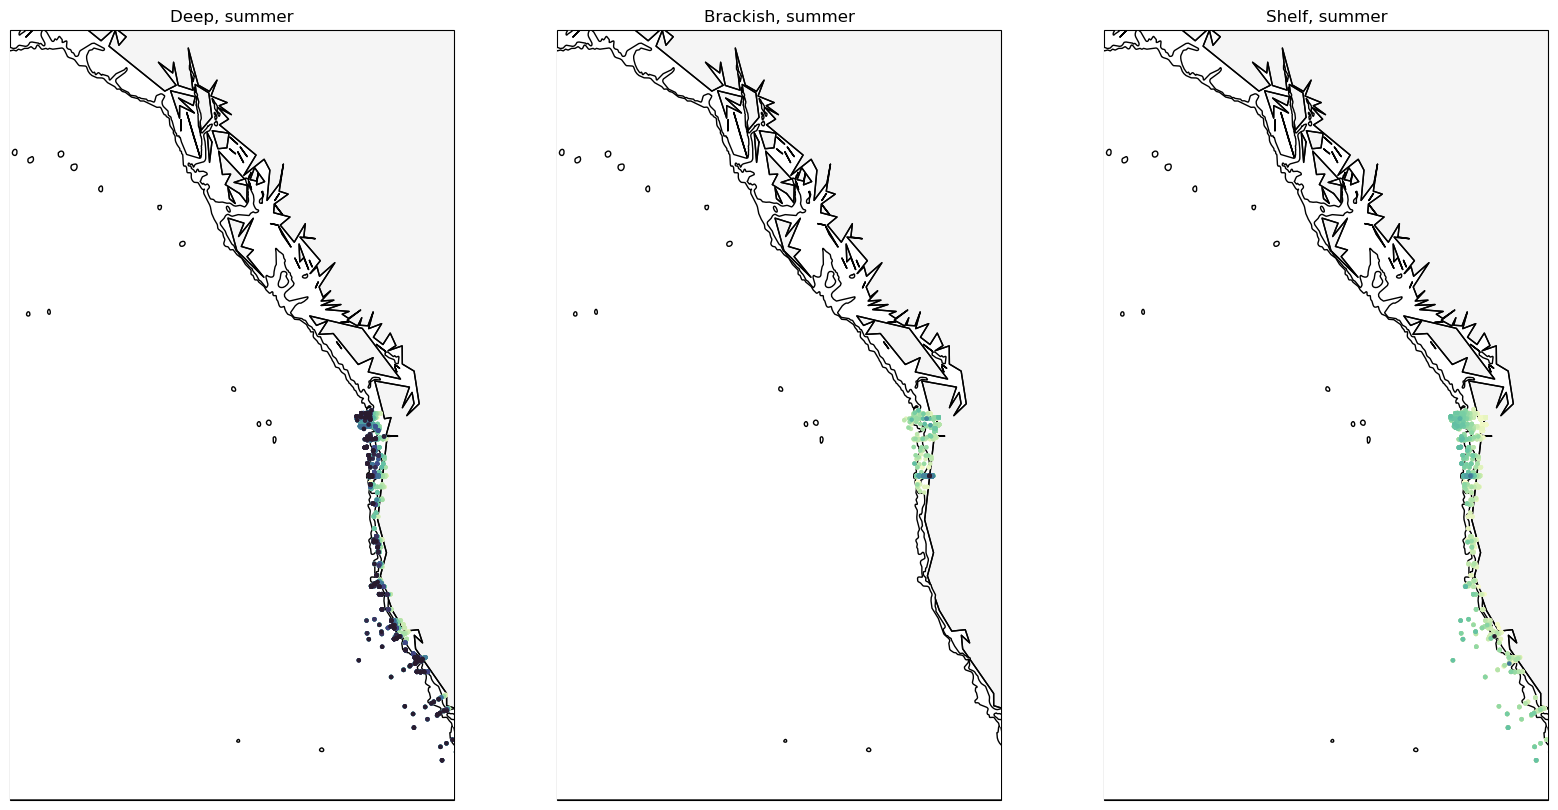

In [14]:
# take a look at where the different water masses are based on our current delineation
# scatter over the map with points coloured by depth

##########
# SUMMER #
##########

fig, ax = plt.subplots(1,3, figsize=(20, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    # and bathymetry..?
    axs.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    axs.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))


# deep
lon = sob['longitude (degrees_east)'][(sob.region == 3)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 3)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 3)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('Deep, summer')

# brackish
lon = sob['longitude (degrees_east)'][(sob.region == 4)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 4)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 4)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('Brackish, summer')

# shelf
lon = sob['longitude (degrees_east)'][(sob.region == 5)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 5)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 5)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[2].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[2].set_title('Shelf, summer')

In [15]:
feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4)

Text(0.5, 1.0, 'Shelf, winter')

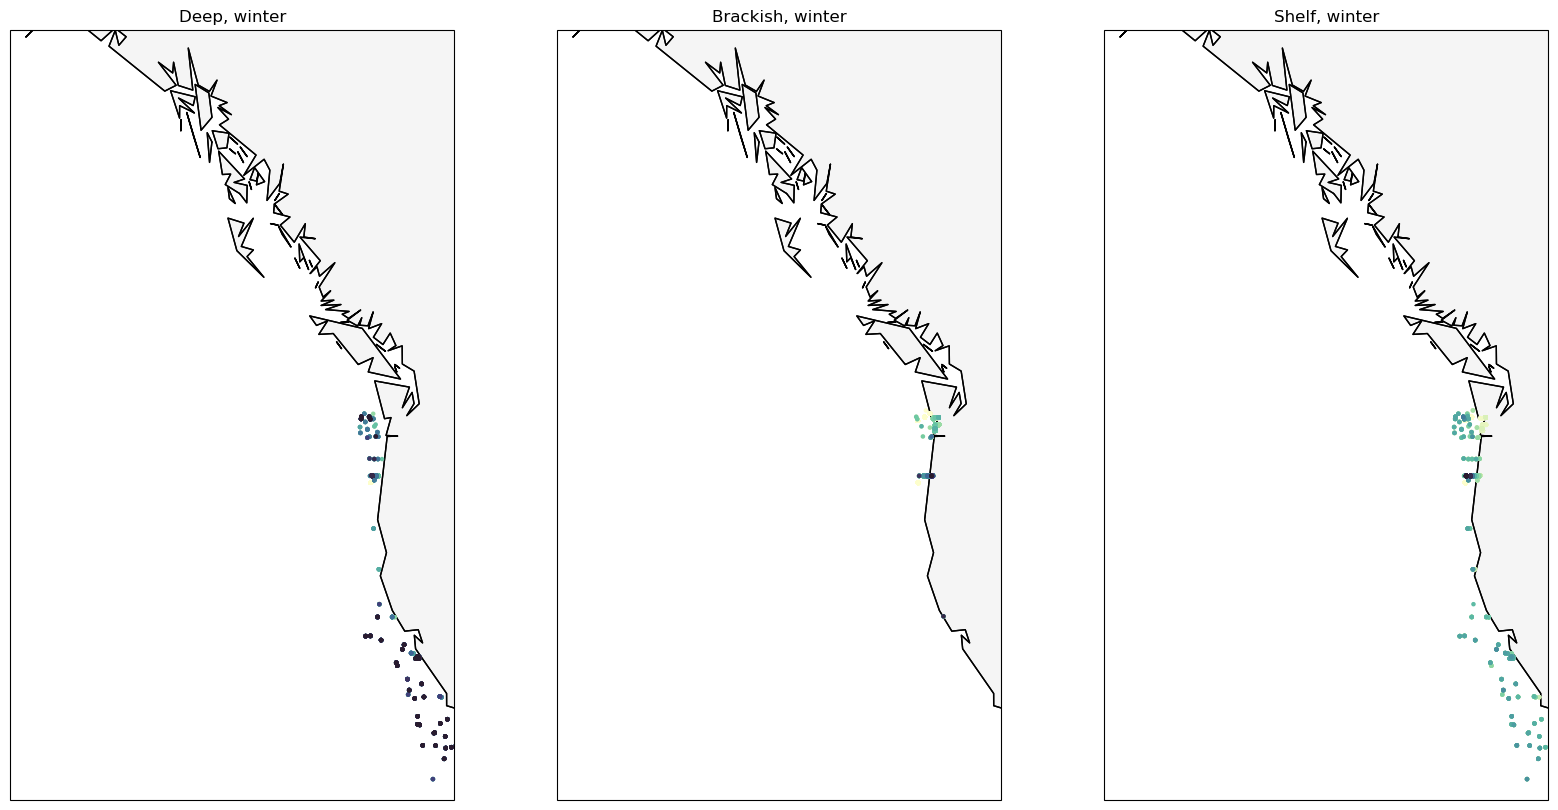

In [16]:
# take a look at where the different water masses are based on our current delineation
# scatter over the map with points coloured by depth

##########
# WINTER #
##########

fig, ax = plt.subplots(1,3, figsize=(20, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# deep
lon = wob['longitude (degrees_east)'][(wob.region == 3)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 3)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 3)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('Deep, winter')

# brackish
lon = wob['longitude (degrees_east)'][(wob.region == 4)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 4)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 4)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('Brackish, winter')

# shelf
lon = wob['longitude (degrees_east)'][(wob.region == 5)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 5)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 5)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[2].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[2].set_title('Shelf, winter')

# North

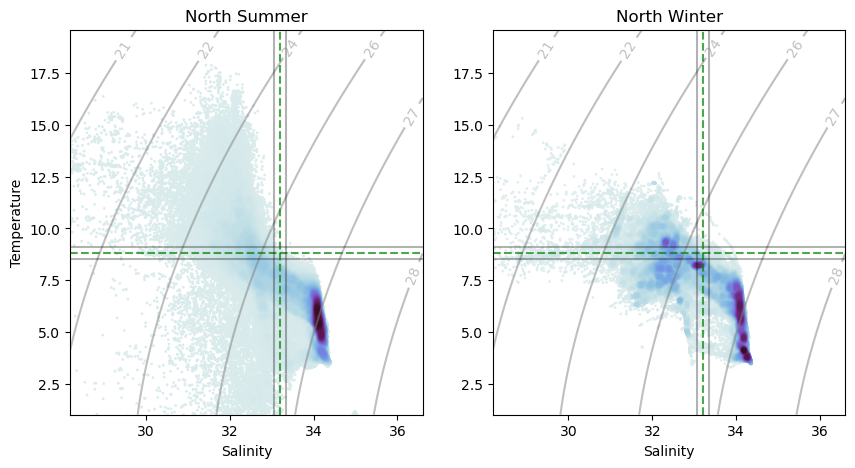

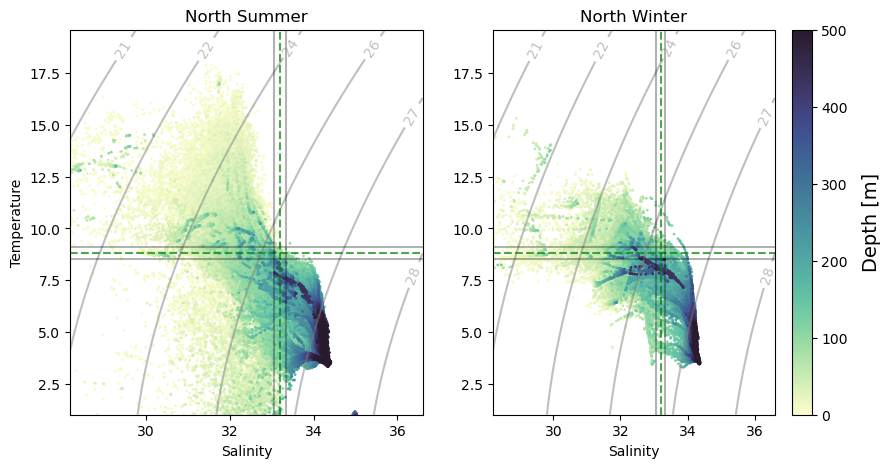

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 2)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 2)].reset_index(drop=True)

bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "North Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 2)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 2)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[1].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "North Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply mean water mass properties from CIOPS analysis
    tmean = 8.8
    ax[i].plot([smin,smax],[tmean,tmean],'g--', alpha=0.7, label='temperature mean')
    ax[i].plot([smin,smax],[tmean+0.28,tmean+0.28],'k', alpha=0.3)
    ax[i].plot([smin,smax],[tmean-0.28,tmean-0.28],'k', alpha=0.3)

    smean = 33.2
    ax[i].plot([smean,smean],[tmin,tmax],'g--',alpha=0.7,label='salinity mean')
    ax[i].plot([smean+0.14,smean+0.14],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([smean-0.14,smean-0.14],[tmin,tmax],'k', alpha=0.3)



#########
# DEPTH #
#########
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 2)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 2)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 2)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
title = "North Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 2)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 2)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 2)].reset_index(drop=True)

# Sort the points by depth, so that the deepest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
sc = ax[1].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
title = "North Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply mean water mass properties from CIOPS analysis
    tmean = 8.8
    ax[i].plot([smin,smax],[tmean,tmean],'g--', alpha=0.7, label='temperature mean')
    ax[i].plot([smin,smax],[tmean+0.28,tmean+0.28],'k', alpha=0.3)
    ax[i].plot([smin,smax],[tmean-0.28,tmean-0.28],'k', alpha=0.3)

    smean = 33.2
    ax[i].plot([smean,smean],[tmin,tmax],'g--',alpha=0.7,label='salinity mean')
    ax[i].plot([smean+0.14,smean+0.14],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([smean-0.14,smean-0.14],[tmin,tmax],'k', alpha=0.3)

Text(0.5, 1.0, 'fresher, summer')

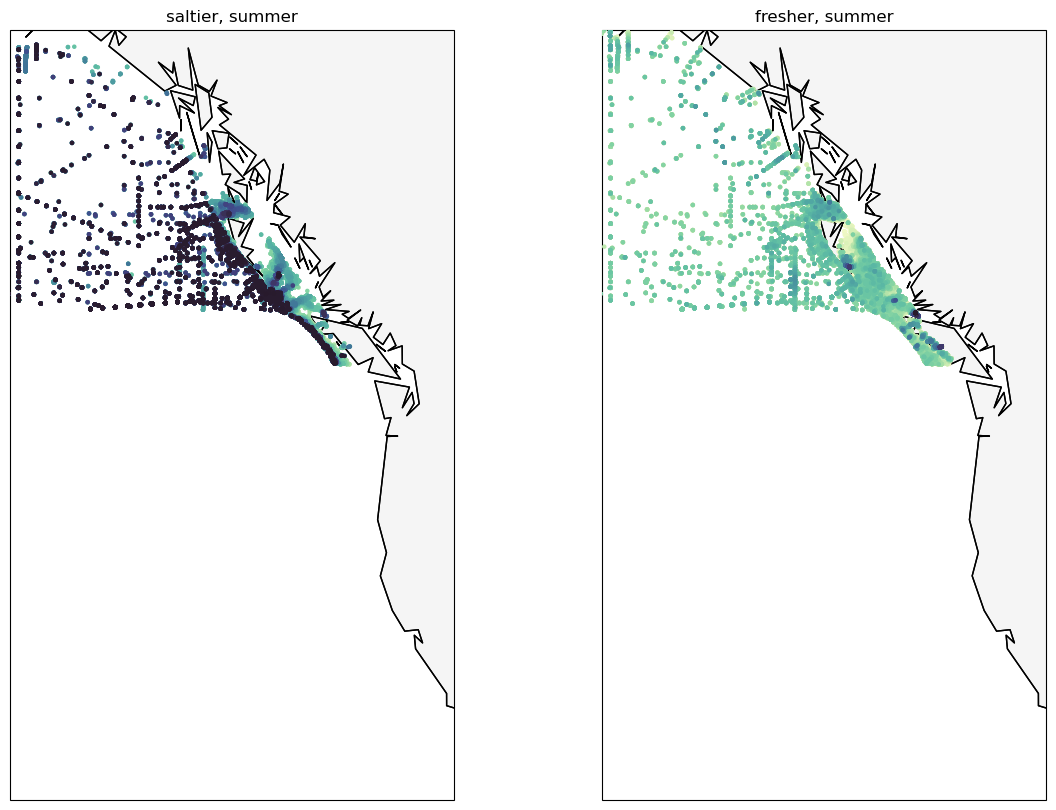

In [18]:
##########
# SUMMER #
##########
sc = 33.5 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# more saline
lon = sob['longitude (degrees_east)'][(sob.region == 2) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 2) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 2) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('saltier, summer')

# less saline
lon = sob['longitude (degrees_east)'][(sob.region == 2) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 2) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 2) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('fresher, summer')

Text(0.5, 1.0, 'colder, winter')

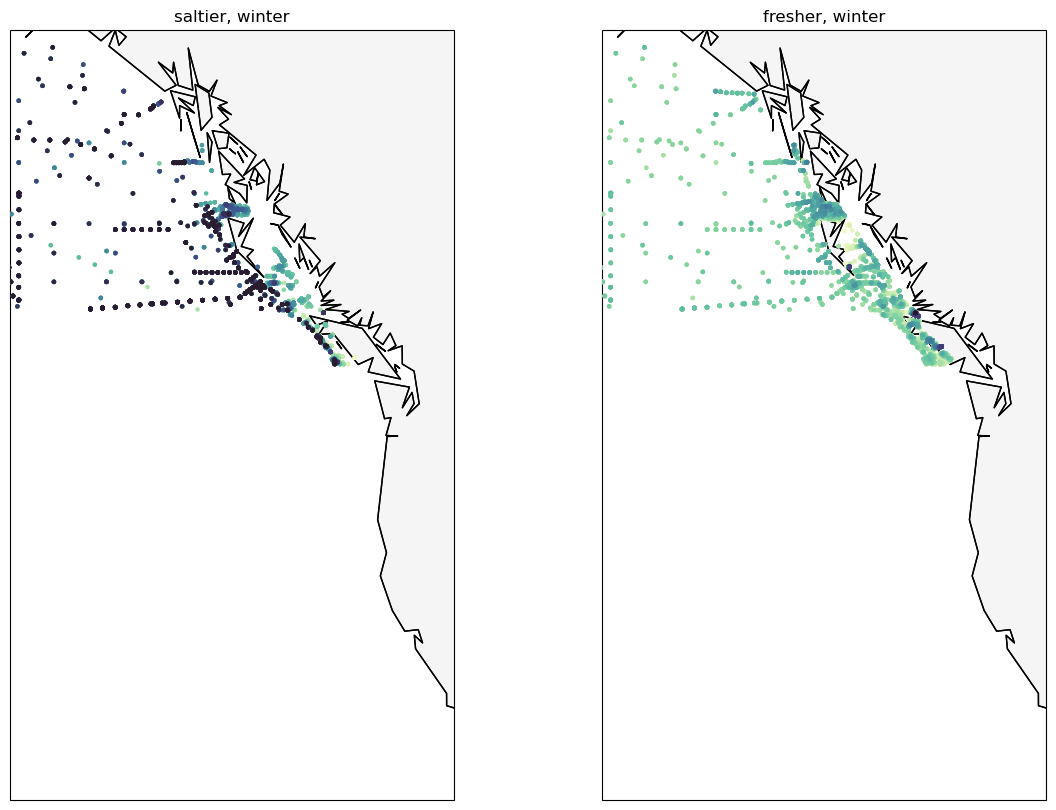

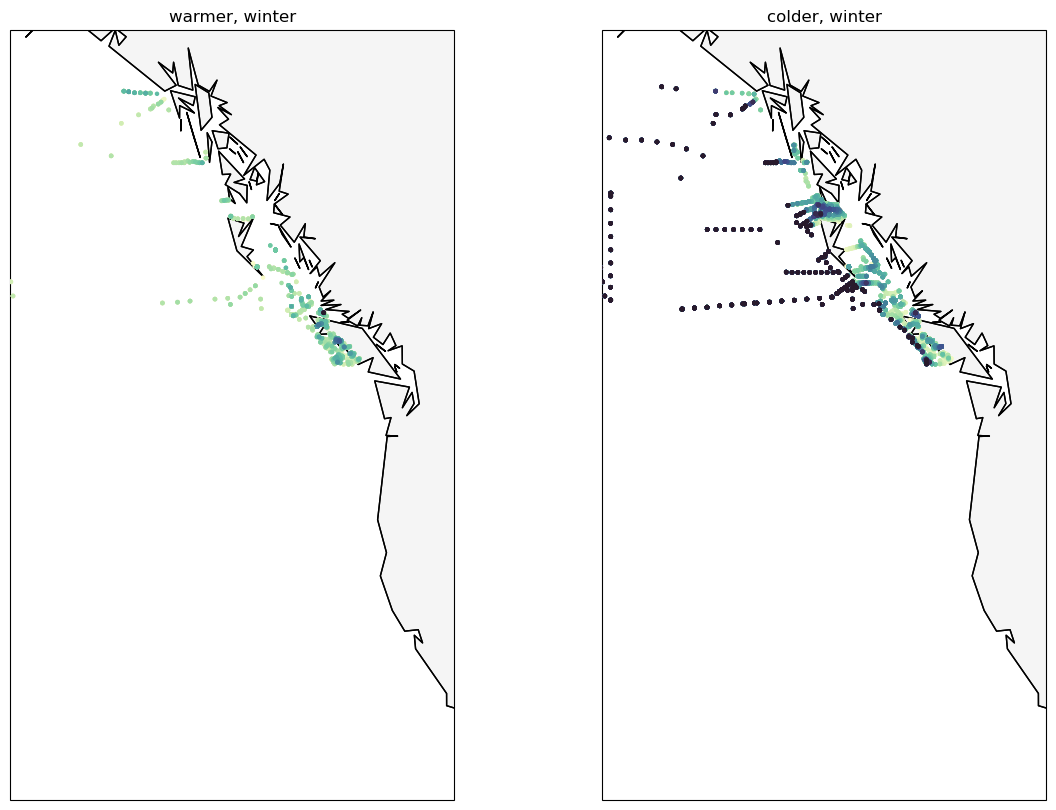

In [19]:
##########
# WINTER #
##########
sc = 33.5 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# more saline
lon = wob['longitude (degrees_east)'][(wob.region == 2) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 2) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 2) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('saltier, winter')

# less saline
lon = wob['longitude (degrees_east)'][(wob.region == 2) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 2) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 2) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('fresher, winter')





# what about temperature?

tc = 9 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# warmer
lon = wob['longitude (degrees_east)'][(wob.region == 2) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 2) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 2) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('warmer, winter')

# colder
lon = wob['longitude (degrees_east)'][(wob.region == 2) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 2) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 2) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('colder, winter')

## Offshore

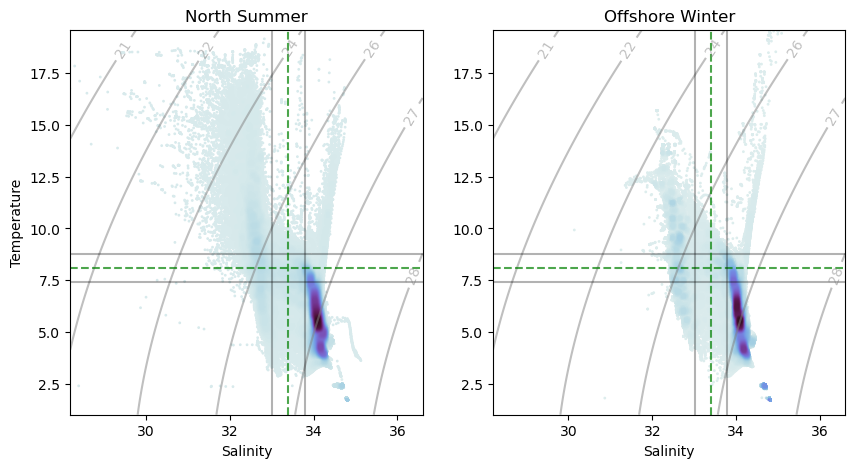

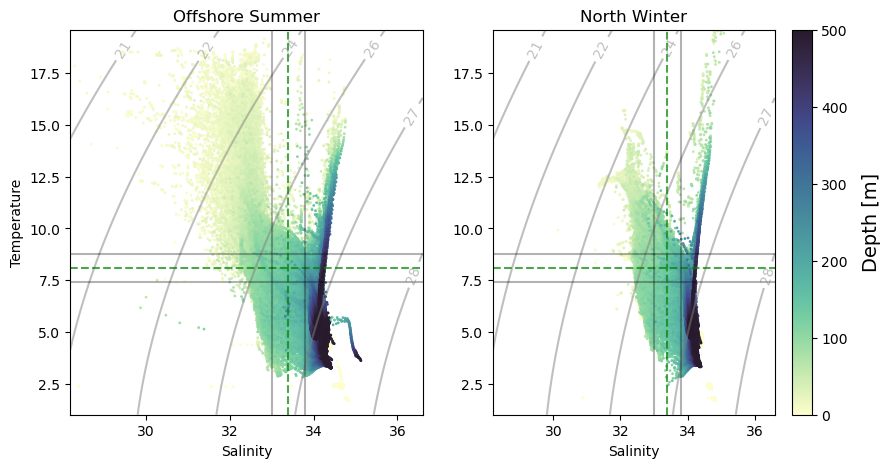

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 1)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 1)].reset_index(drop=True)

bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "North Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 1)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 1)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[1].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "Offshore Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply mean water mass properties from CIOPS analysis
    tmean = 8.1
    ax[i].plot([smin,smax],[tmean,tmean],'g--', alpha=0.7, label='temperature mean')
    ax[i].plot([smin,smax],[tmean+0.67,tmean+0.67],'k', alpha=0.3)
    ax[i].plot([smin,smax],[tmean-0.67,tmean-0.67],'k', alpha=0.3)

    smean = 33.4
    ax[i].plot([smean,smean],[tmin,tmax],'g--',alpha=0.7,label='salinity mean')
    ax[i].plot([smean+0.39,smean+0.39],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([smean-0.39,smean-0.39],[tmin,tmax],'k', alpha=0.3)



#########
# DEPTH #
#########
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 1)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 1)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 1)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
title = "Offshore Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 1)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 1)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 1)].reset_index(drop=True)

# Sort the points by depth, so that the deepest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
sc = ax[1].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
title = "North Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply mean water mass properties from CIOPS analysis
    tmean = 8.1
    ax[i].plot([smin,smax],[tmean,tmean],'g--', alpha=0.7, label='temperature mean')
    ax[i].plot([smin,smax],[tmean+0.67,tmean+0.67],'k', alpha=0.3)
    ax[i].plot([smin,smax],[tmean-0.67,tmean-0.67],'k', alpha=0.3)

    smean = 33.4
    ax[i].plot([smean,smean],[tmin,tmax],'g--',alpha=0.7,label='salinity mean')
    ax[i].plot([smean+0.39,smean+0.39],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([smean-0.39,smean-0.39],[tmin,tmax],'k', alpha=0.3)

Text(0.5, 1.0, 'colder, summer')

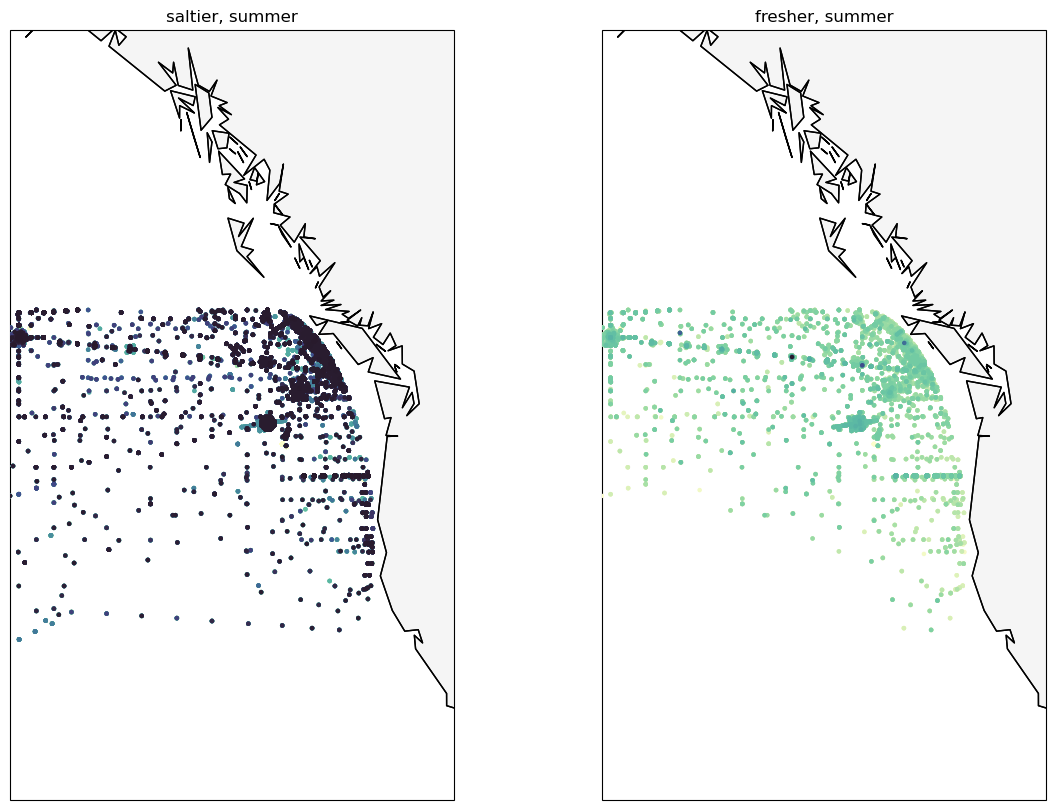

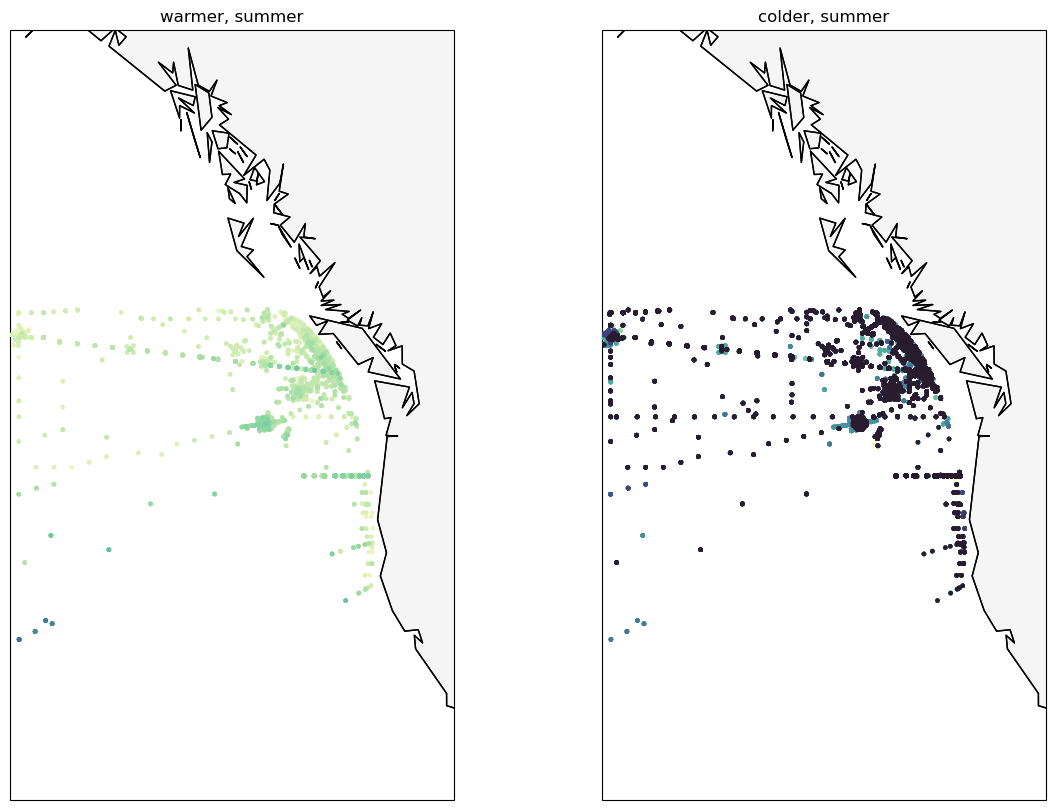

In [ ]:
##########
# SUMMER #
##########
sc = 33 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# more saline
lon = sob['longitude (degrees_east)'][(sob.region == 1) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 1) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 1) & (sob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('saltier, summer')

# less saline
lon = sob['longitude (degrees_east)'][(sob.region == 1) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 1) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 1) & (sob['salinity (g kg-1)']<sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('fresher, summer')





# what about temperature?

tc = 10 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# warmer
lon = sob['longitude (degrees_east)'][(sob.region == 1) & (sob['temperature (degC)']>=tc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 1) & (sob['temperature (degC)']>=tc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 1) & (sob['temperature (degC)']>=tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('warmer, summer')

# colder
lon = sob['longitude (degrees_east)'][(sob.region == 1) & (sob['temperature (degC)']<tc)].reset_index(drop=True)
lat = sob['latitude (degrees_north)'][(sob.region == 1) & (sob['temperature (degC)']<tc)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 1) & (sob['temperature (degC)']<tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('colder, summer')

Text(0.5, 1.0, 'colder, winter')

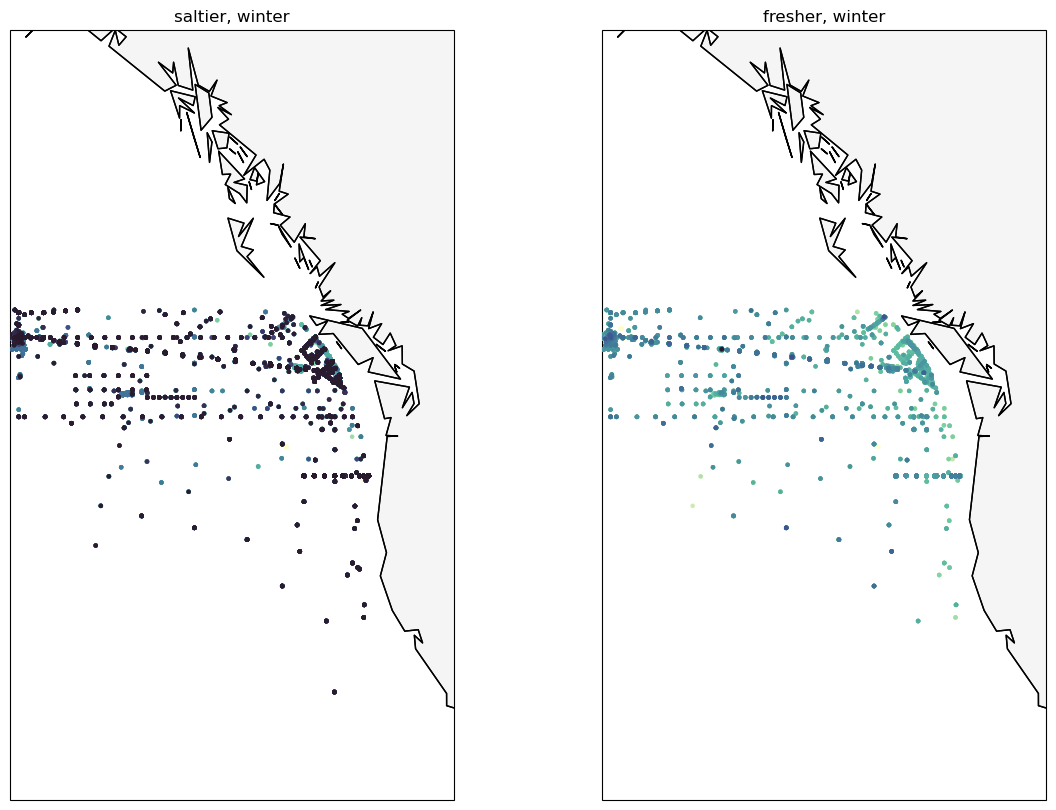

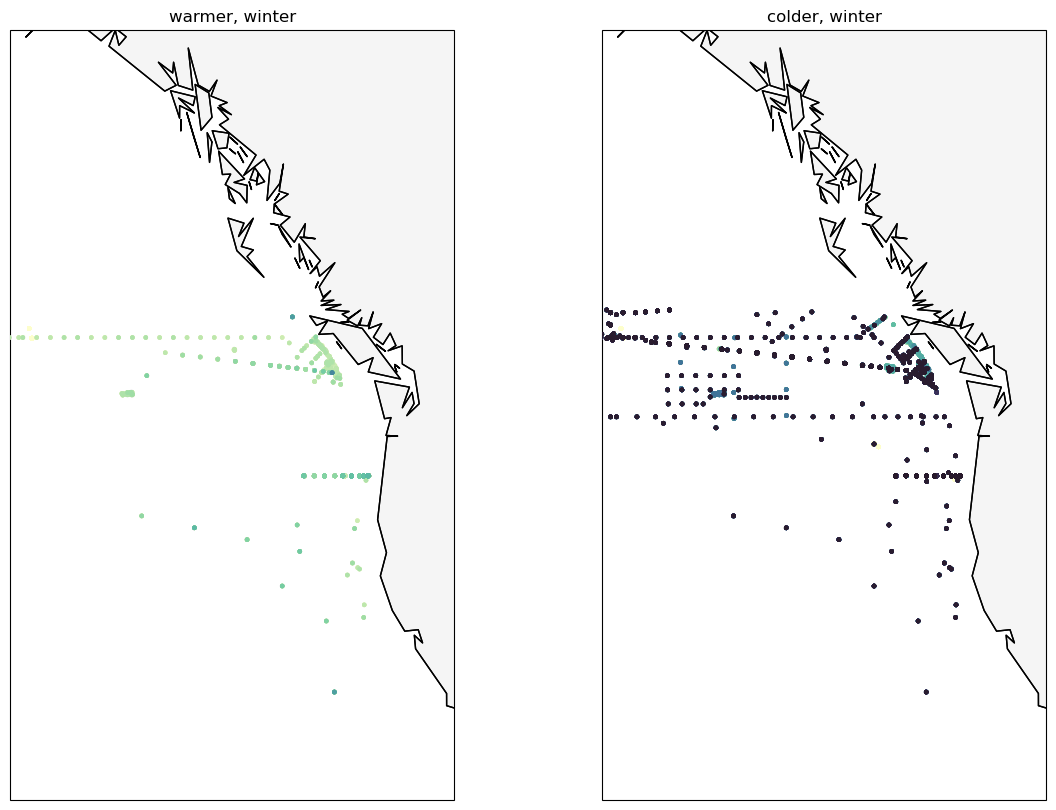

In [22]:
##########
# winter #
##########
sc = 33 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# more salinerr
lon = wob['longitude (degrees_east)'][(wob.region == 1) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 1) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 1) & (wob['salinity (g kg-1)']>=sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('saltier, winter')

# less saline
lon = wob['longitude (degrees_east)'][(wob.region == 1) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 1) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 1) & (wob['salinity (g kg-1)']<sc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('fresher, winter')





# what about temperature?

tc = 10 # looking into is salinity cuttoff leads to dractically different locations

fig, ax = plt.subplots(1,2, figsize=(14, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)

    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    axs.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# warmer
lon = wob['longitude (degrees_east)'][(wob.region == 1) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 1) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 1) & (wob['temperature (degC)']>=tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[0].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[0].set_title('warmer, winter')

# colder
lon = wob['longitude (degrees_east)'][(wob.region == 1) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
lat = wob['latitude (degrees_north)'][(wob.region == 1) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 1) & (wob['temperature (degC)']<tc)].reset_index(drop=True)
idx = z.argsort()
lon, lat, z = lon[idx], lat[idx], z[idx]

ax[1].scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
ax[1].set_title('colder, winter')